# Vuelos y ventas a marca

Este notebook une informacion de vuelos y ventas y genera un dataframe por marca seleccionada.

## Librerias

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List, Any
import gc
import re

from unidecode import unidecode
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

import univariate_utils, multivariate_utils

## Constantes

In [2]:
CLEAN_FLIGHTS_FILE = "data/clean_flights.parquet"

In [3]:
CLEAN_SALES_FILE = "data/clean_sales.parquet"

In [4]:
MUELLE_FILE = "data/muelle.parquet"

## Utils

In [5]:
def clip_data_by_iqr(df, col, strategy, iqr_multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    bottom_limit = Q1 - iqr_multiplier * IQR
    top_limit = Q3 + iqr_multiplier * IQR
    
    is_low = df[col] <= bottom_limit
    is_high = df[col] >= top_limit
    
    if strategy == "bottom":
        df.loc[is_low, col] = bottom_limit
    if strategy == "top":
        df.loc[is_high, col] = top_limit
    else:
        df.loc[is_low, col] = bottom_limit
        df.loc[is_high, col] = top_limit

## Ejecucion

### Carga de dataframes

In [6]:
df_hourly_flights = pd.read_parquet(CLEAN_FLIGHTS_FILE)

In [7]:
df_sales = pd.read_parquet(CLEAN_SALES_FILE)

### Agrupacion de ventas por hora y marca

Se hace un corte de las ventas por iqr para evitar outliers.

In [8]:
hourly_sales_per_marca = {}
for marca, df_marca_sales in df_sales.groupby("marca"):
    hourly_sales_per_marca[marca] = df_marca_sales.groupby(
        ["muelle_venta", "fecha_venta", "hora_venta"]
    ).agg({
        "transacciones_venta": "sum",
        "valor_venta": "sum"
    }).reset_index(drop=False)

marca 1


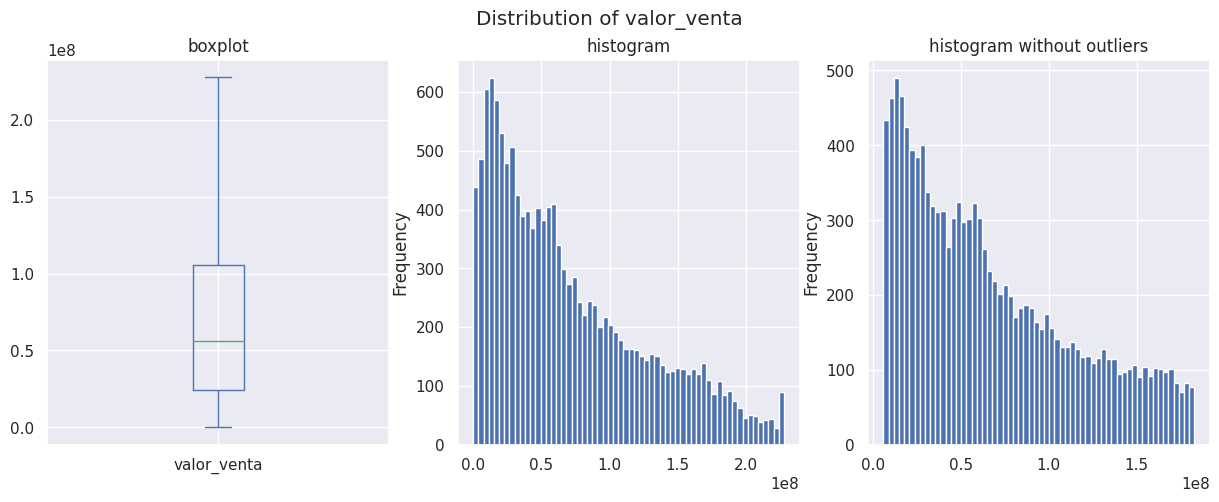

marca 10


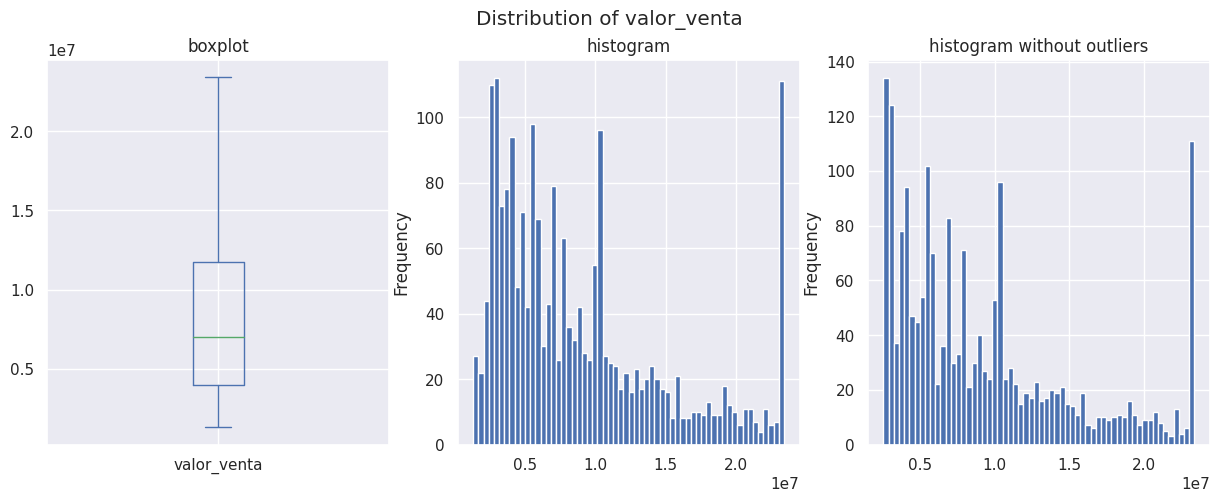

marca 2


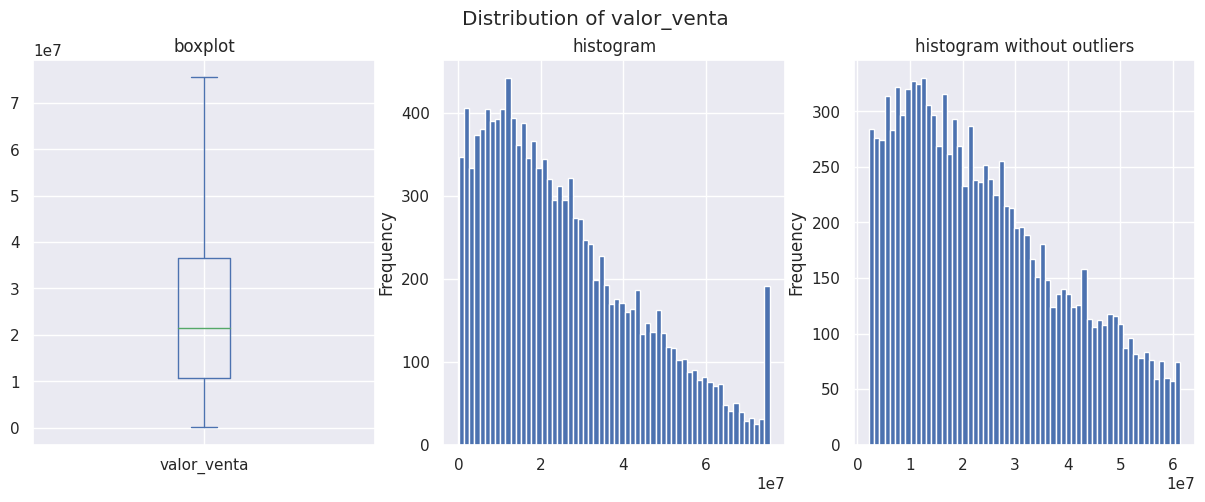

marca 3


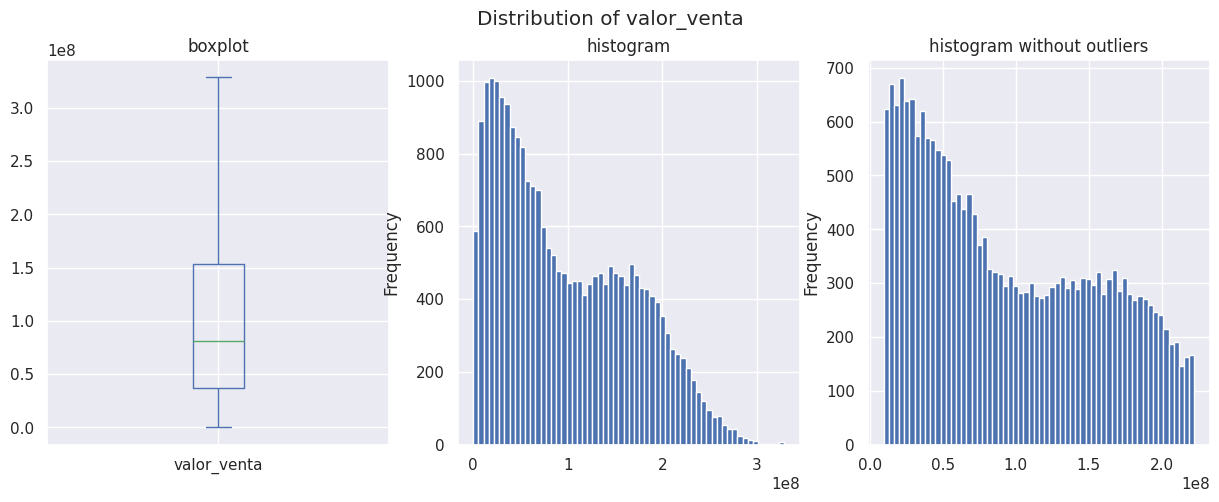

marca 5


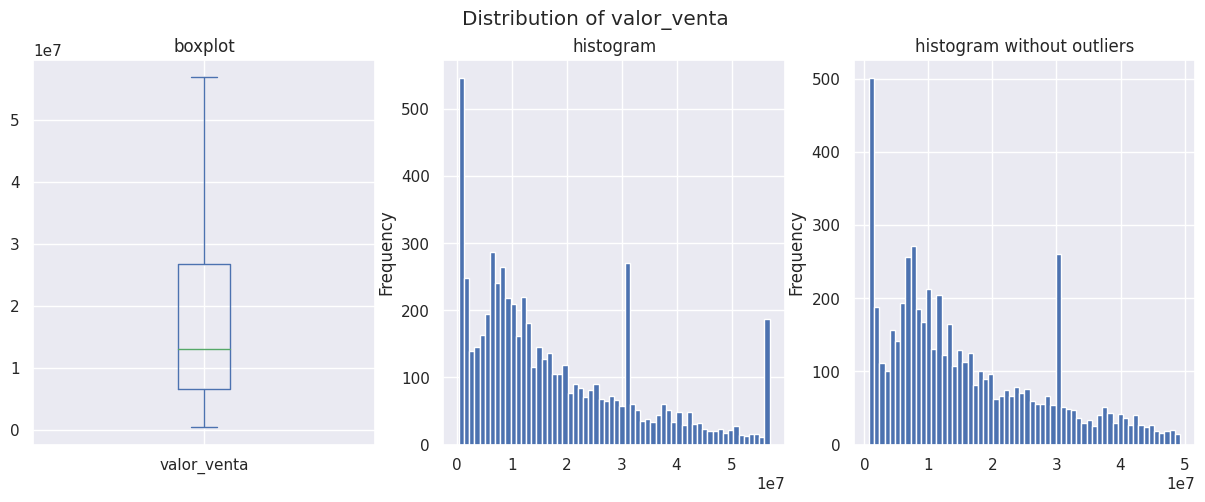

marca 6


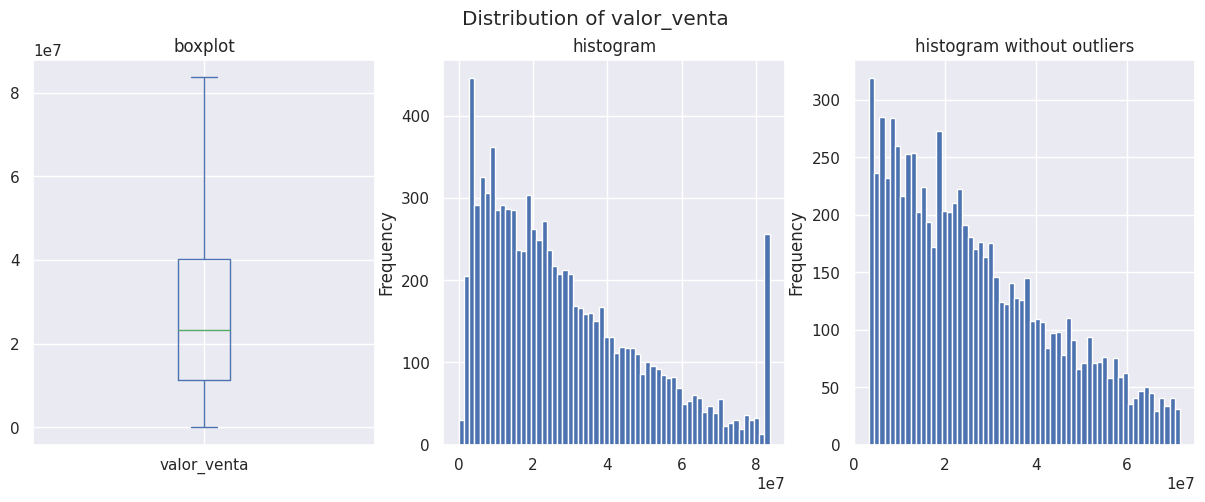

marca 7


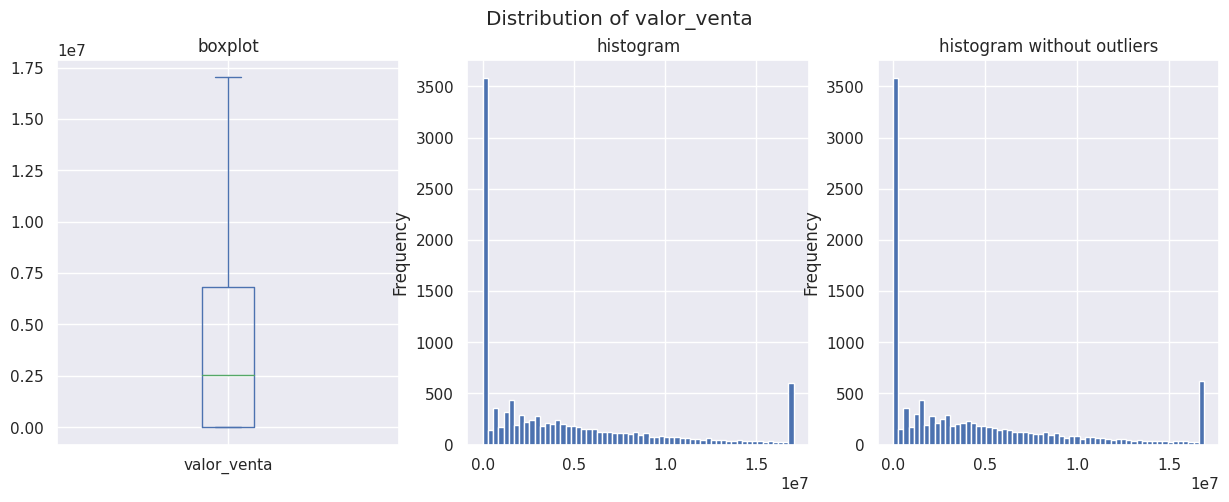

marca 9


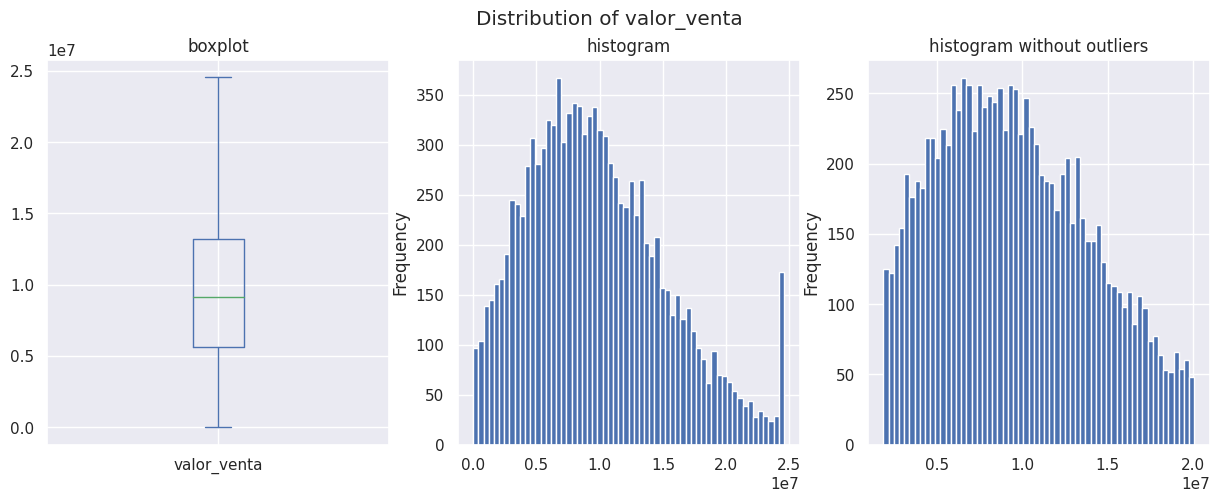

In [9]:
for marca, df_marca_sales in df_sales.groupby("marca"):
    print(marca)
    clip_data_by_iqr(df_marca_sales, "valor_venta", "top", 1.5)
    univariate_utils.plot_column_distribution(
            df_marca_sales,
            "valor_venta",
            (15,5),
            60
        )

### Integracion de datos con datos de ventas

#### Seleccion de muelle (Dimension de relevancia)
El unico muelle en comun es muelle internacional oriente, asi que se toman los datos de este muelle y se hace una union entre vuelos y ventas agrupadas por hora con la condicion de que las ventas representan las ventas en las dos horas anteriores al vuelo.

In [10]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    print(
        marca,
        df_marca_sales["muelle_venta"].unique().tolist()
    )

marca 1 ['muelle internacional oriente']
marca 10 ['muelle internacional oriente']
marca 2 ['muelle internacional oriente']
marca 3 ['muelle internacional centro', 'muelle internacional oriente']
marca 5 ['muelle internacional oriente']
marca 6 ['muelle internacional oriente']
marca 7 ['muelle internacional oriente']
marca 9 ['muelle internacional oriente']


In [11]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    df_marca_sales = df_marca_sales[
        df_marca_sales["muelle_venta"] == "muelle internacional oriente"
    ].copy(deep=True)

In [12]:
df_hourly_flights = df_hourly_flights[
    df_hourly_flights["Muelle"] == "muelle internacional oriente"
]

#### Merge de dataframes
Se ignora la hora para poder operar la diferencia de 2 horas. Por otro lado se eliminan las filas con nulos en menos del 7% de las filas (aunque se considera eliminar la marca 10 por su alto numero de nulos encima de 20%).

In [13]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    hourly_sales_per_marca[marca] = df_hourly_flights.merge(
        df_marca_sales,
        left_on=["Muelle", "STD_date"],
        right_on=["muelle_venta", "fecha_venta"],
        how="left"
    )

In [14]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    print(marca)
    df_marca_sales.drop(
        columns=[
            "muelle_venta"
        ],
        inplace=True
    )
    print(df_marca_sales.isnull().sum()/len(df_marca_sales))

marca 1
Destino                        0.000000
Tipo de vuelo                  0.000000
Sala                           0.000000
Muelle                         0.000000
FECHA DIA                      0.000000
AEROLÍNEA                      0.000000
Tipo aerolínea                 0.000000
STD                            0.000000
Pasajeros saliendo             0.000000
Hora entera                    0.000000
Semana                         0.000000
Mes                            0.000000
Día                            0.000000
Año                            0.000000
STD_date                       0.000000
Pasajeros por Muelle y Hora    0.000000
Porcentaje pasajeros vuelo     0.000000
fecha_venta                    0.020226
hora_venta                     0.020226
transacciones_venta            0.020226
valor_venta                    0.020226
dtype: float64
marca 10
Destino                        0.00000
Tipo de vuelo                  0.00000
Sala                           0.00000
Muelle     

In [15]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    hourly_sales_per_marca[marca] = df_marca_sales[
        ~df_marca_sales["hora_venta"].isnull()
    ].copy(deep=True)
    print(df_marca_sales.isnull().sum()/len(df_marca_sales))

Destino                        0.000000
Tipo de vuelo                  0.000000
Sala                           0.000000
Muelle                         0.000000
FECHA DIA                      0.000000
AEROLÍNEA                      0.000000
Tipo aerolínea                 0.000000
STD                            0.000000
Pasajeros saliendo             0.000000
Hora entera                    0.000000
Semana                         0.000000
Mes                            0.000000
Día                            0.000000
Año                            0.000000
STD_date                       0.000000
Pasajeros por Muelle y Hora    0.000000
Porcentaje pasajeros vuelo     0.000000
fecha_venta                    0.020226
hora_venta                     0.020226
transacciones_venta            0.020226
valor_venta                    0.020226
dtype: float64
Destino                        0.00000
Tipo de vuelo                  0.00000
Sala                           0.00000
Muelle                      

#### Reintegrando timestamp de venta (dimension de conformidad)

Este formato es necesario para poder encontrar las horas de venta anteriores al vuelo.

In [16]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    df_marca_sales["timestamp_venta"] = (
        pd.to_datetime(df_marca_sales["fecha_venta"])
        + pd.to_timedelta(
            df_marca_sales["hora_venta"],
            unit="hours"
        )
    )

#### Filtrado de ventas en las dos horas anteriores

In [17]:
for marca, df_marca_sales in hourly_sales_per_marca.items():

    df_marca_sales["STD"] = pd.to_datetime(df_marca_sales["STD"])
    df_marca_sales["time_difference"] = (
        (df_marca_sales["STD"] - df_marca_sales["timestamp_venta"]).dt.seconds
        / float(3600)
    )
    is_sale_before_flight = (
        (df_marca_sales["time_difference"] <= 2.0)
        & (df_marca_sales["STD"] >= df_marca_sales["timestamp_venta"])
    )
    hourly_sales_per_marca[marca] = df_marca_sales[is_sale_before_flight].copy(deep=True)

#### Re agrupacion por hora y vuelo

Se evalua que no se generen valores anomalos al agrupar (dimension de conformidad a nivel de atributo)

In [18]:
hourly_sales_per_marca["marca 1"]

,Destino,Tipo de vuelo,Sala,Muelle,FECHA DIA,AEROLÍNEA,Tipo aerolínea,STD,Pasajeros saliendo,Hora entera,Semana,Mes,Día,Año,STD_date,Pasajeros por Muelle y Hora,Porcentaje pasajeros vuelo,fecha_venta,hora_venta,transacciones_venta,valor_venta,timestamp_venta,time_difference
52,amsterdam,internacional,a1,muelle internacional oriente,martes,klm cia,legacy,2022-01-04 16:05:00,124.0,15,1,1,4,2022,2022-01-04,124.0,1.000000,2022-01-04,15.0,92.0,107954452.5,2022-01-04 15:00:00,1.083333
53,amsterdam,internacional,a1,muelle internacional oriente,martes,klm cia,legacy,2022-01-04 16:05:00,124.0,15,1,1,4,2022,2022-01-04,124.0,1.000000,2022-01-04,16.0,80.0,81808200.0,2022-01-04 16:00:00,0.083333
76,amsterdam,internacional,a1,muelle internacional oriente,jueves,klm cia,legacy,2022-01-06 16:05:00,194.0,16,1,1,6,2022,2022-01-06,370.0,0.524324,2022-01-06,15.0,56.0,56634740.0,2022-01-06 15:00:00,1.083333
77,amsterdam,internacional,a1,muelle internacional oriente,jueves,klm cia,legacy,2022-01-06 16:05:00,194.0,16,1,1,6,2022,2022-01-06,370.0,0.524324,2022-01-06,16.0,41.0,39942760.0,2022-01-06 16:00:00,0.083333
100,amsterdam,internacional,a1,muelle internacional oriente,viernes,klm cia,legacy,2022-01-14 16:05:00,217.0,16,2,1,14,2022,2022-01-14,217.0,1.000000,2022-01-14,15.0,55.0,42336460.0,2022-01-14 15:00:00,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168494,yuma arizona,internacional,rori,muelle internacional oriente,jueves,aerolinea de vuelo charter,charter,2022-06-02 09:15:00,39.0,15,22,6,2,2022,2022-06-02,39.0,1.000000,2022-06-02,8.0,33.0,24296500.0,2022-06-02 08:00:00,1.250000
1168495,yuma arizona,internacional,rori,muelle internacional oriente,jueves,aerolinea de vuelo charter,charter,2022-06-02 09:15:00,39.0,15,22,6,2,2022,2022-06-02,39.0,1.000000,2022-06-02,9.0,33.0,18492500.0,2022-06-02 09:00:00,0.250000
1168516,yuma arizona,internacional,rori,muelle internacional oriente,viernes,menzies aviation colombia s a s,legacy,2022-10-07 08:00:00,34.0,9,40,10,7,2022,2022-10-07,34.0,1.000000,2022-10-07,6.0,88.0,65587540.0,2022-10-07 06:00:00,2.000000
1168517,yuma arizona,internacional,rori,muelle internacional oriente,viernes,menzies aviation colombia s a s,legacy,2022-10-07 08:00:00,34.0,9,40,10,7,2022,2022-10-07,34.0,1.000000,2022-10-07,7.0,69.0,52928880.0,2022-10-07 07:00:00,1.000000


In [19]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    hourly_sales_per_marca[marca] = df_marca_sales.groupby([
        "Destino",
        "Tipo de vuelo",
        "Sala",
        "Muelle",
        "AEROLÍNEA",
        "Tipo aerolínea",
        "STD",
        "Hora entera"
    ]).agg({
        "FECHA DIA": "min",
        "Pasajeros saliendo": "min",
        "Semana": "min",
        "Mes": "min",
        "Día": "min",
        "Año": "min",
        "Pasajeros por Muelle y Hora": "min",
        "Porcentaje pasajeros vuelo": "min",
        "valor_venta": "sum"
    }).reset_index(drop=False)

marca 1


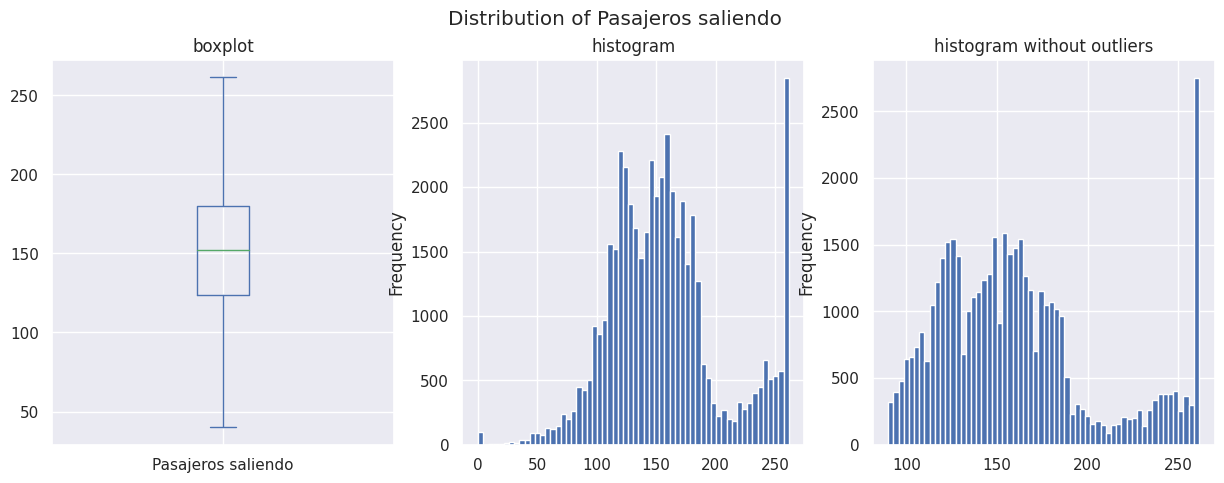

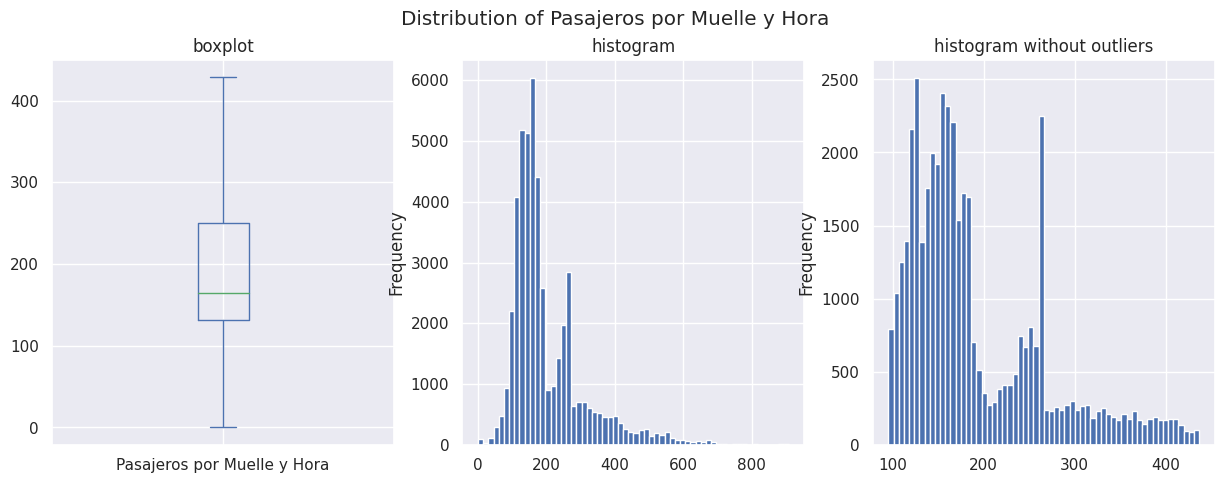

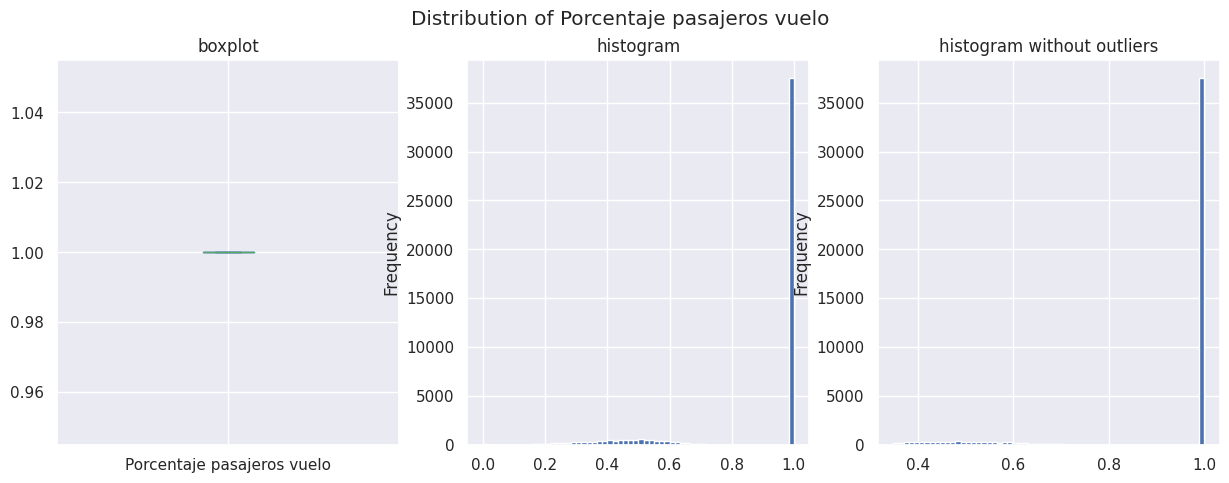

marca 10


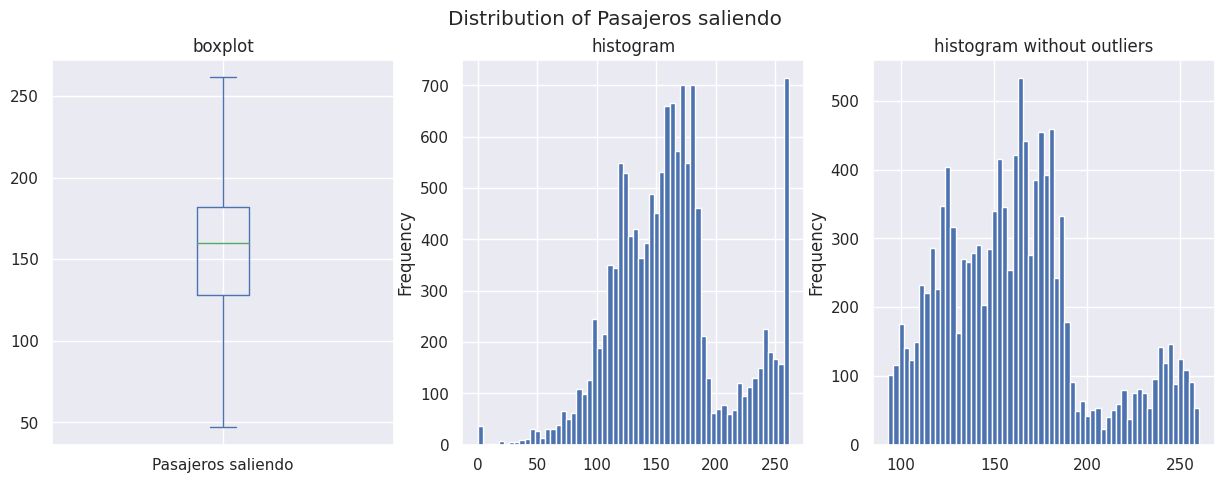

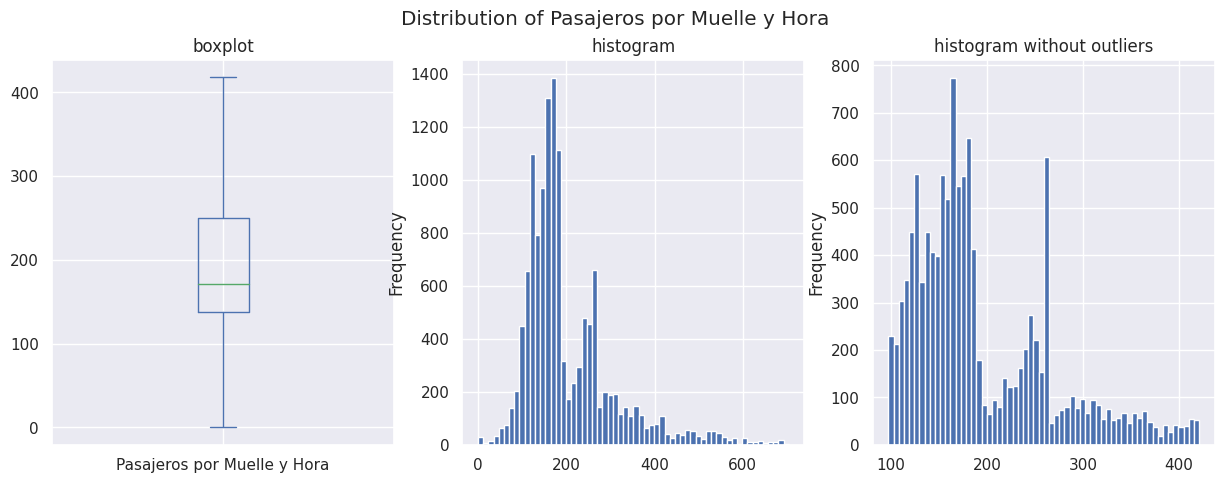

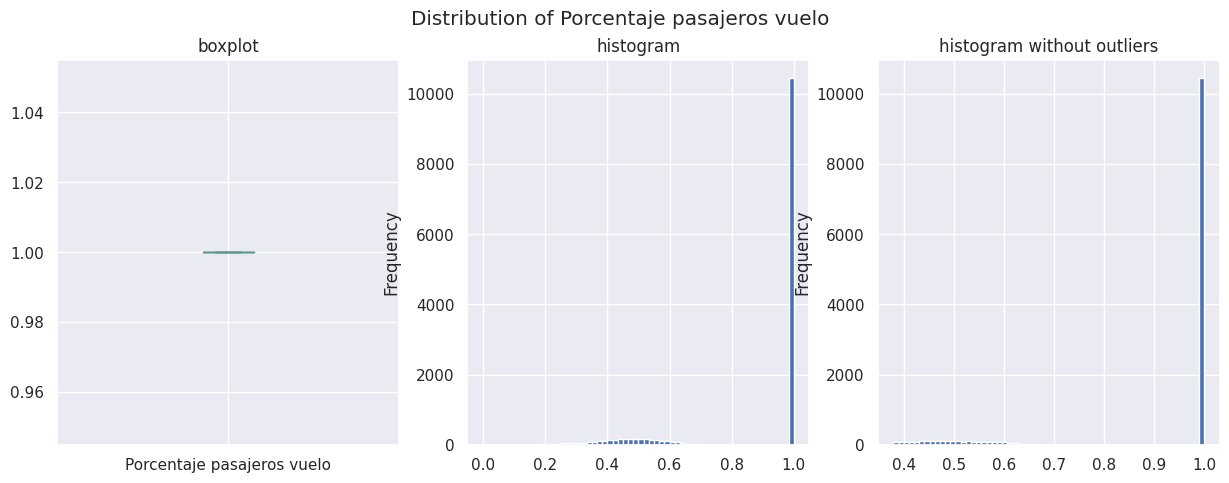

marca 2


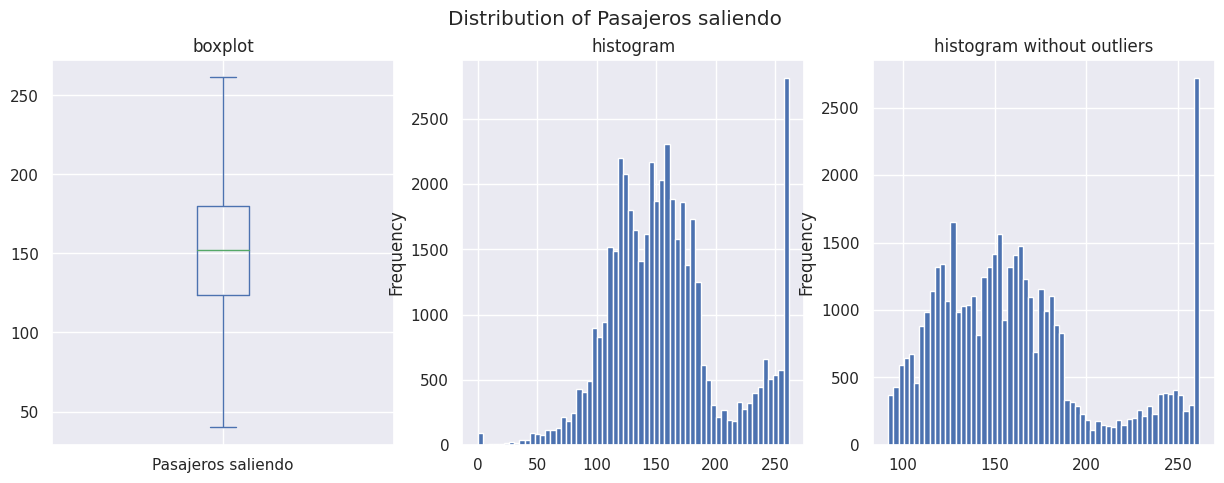

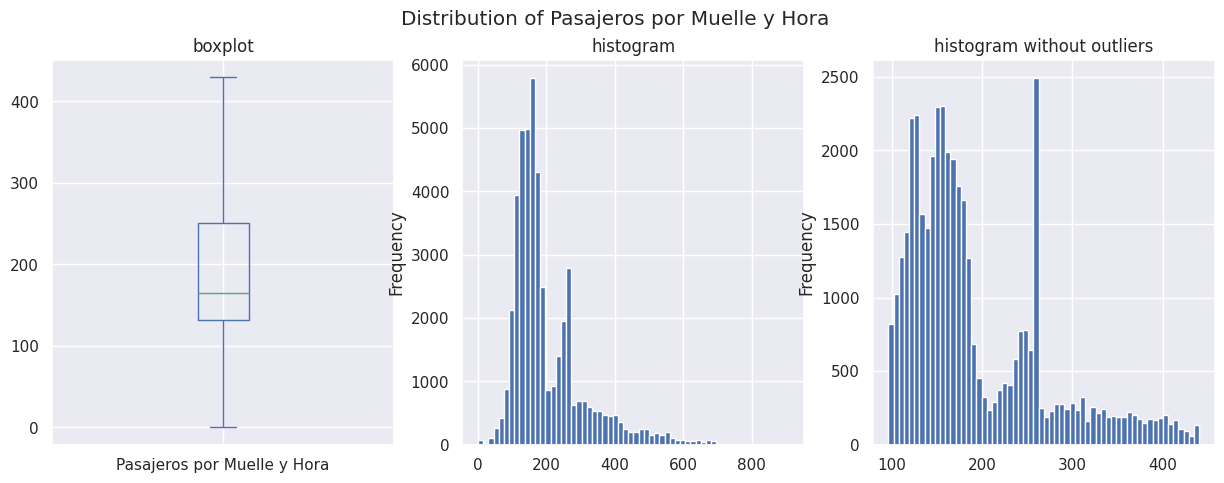

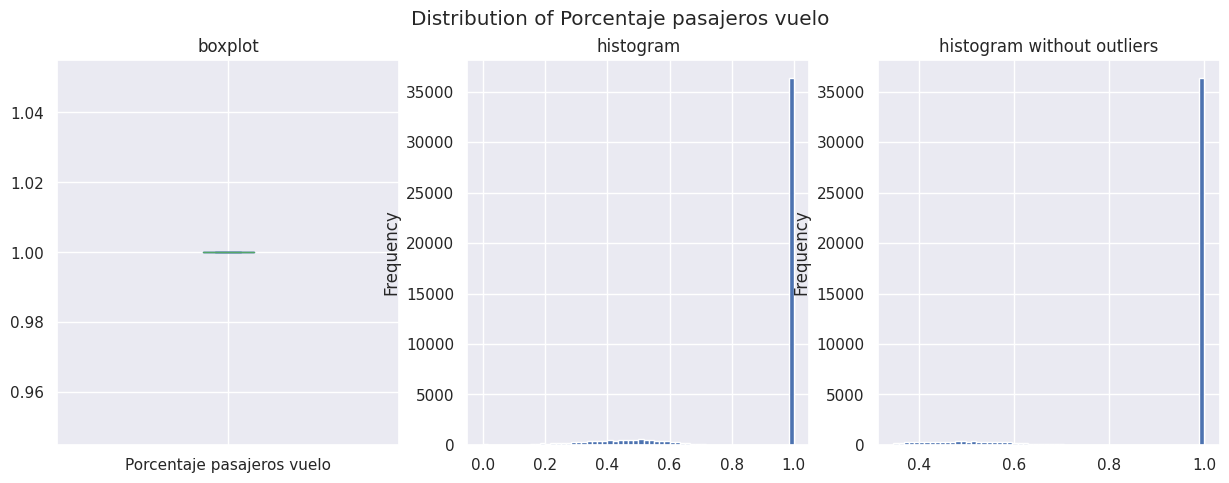

marca 3


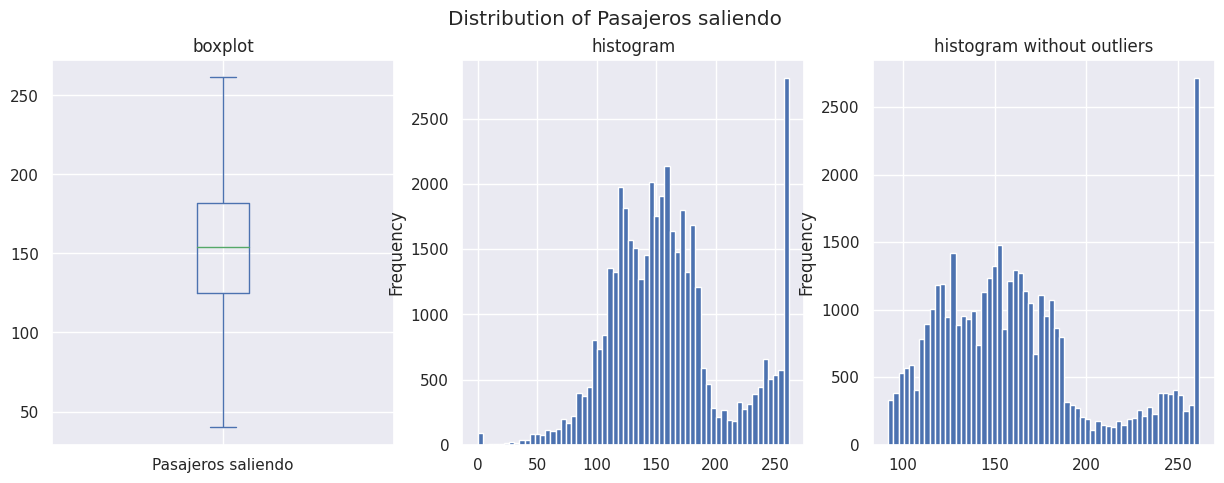

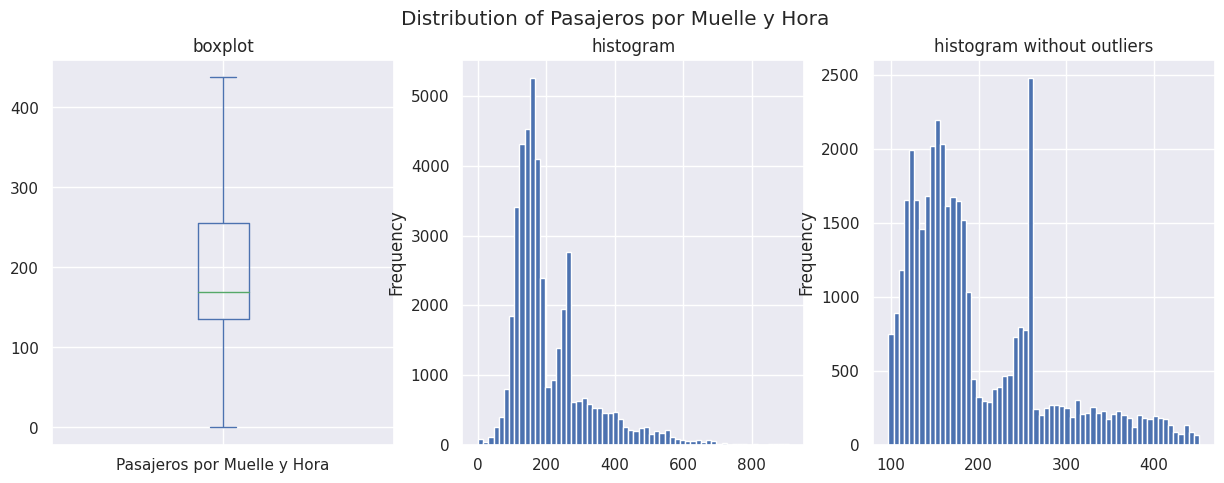

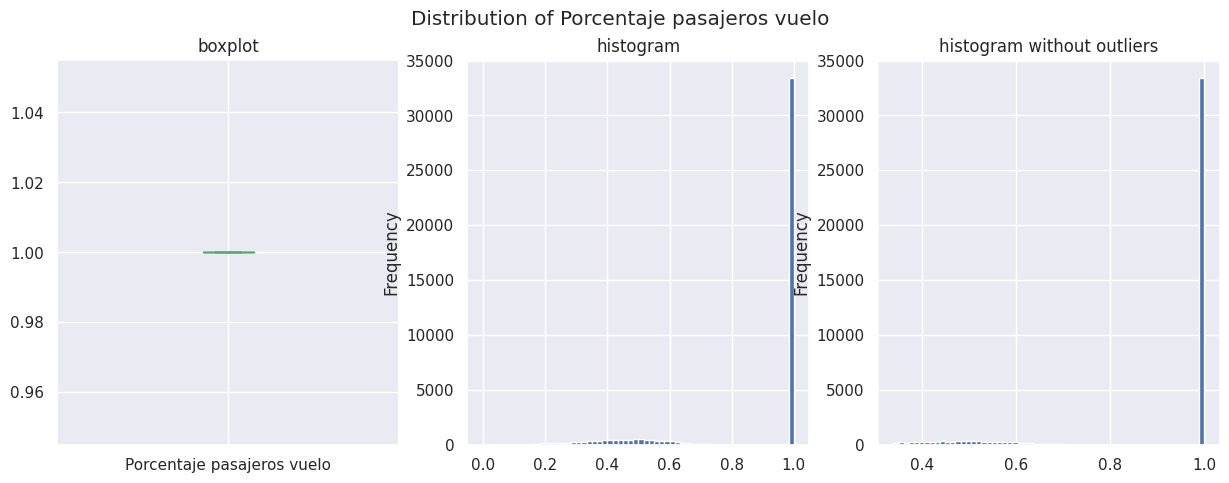

marca 5


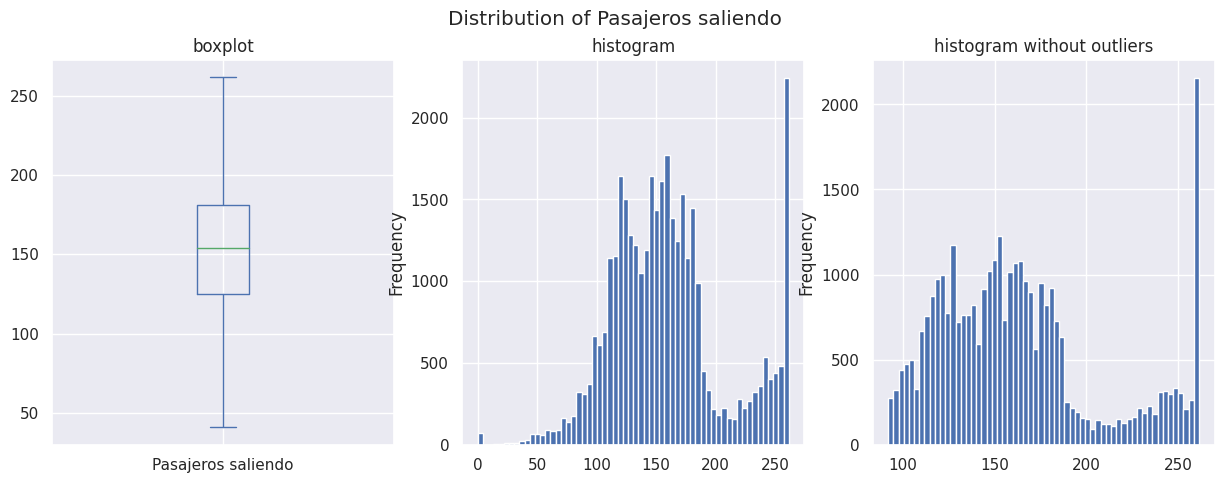

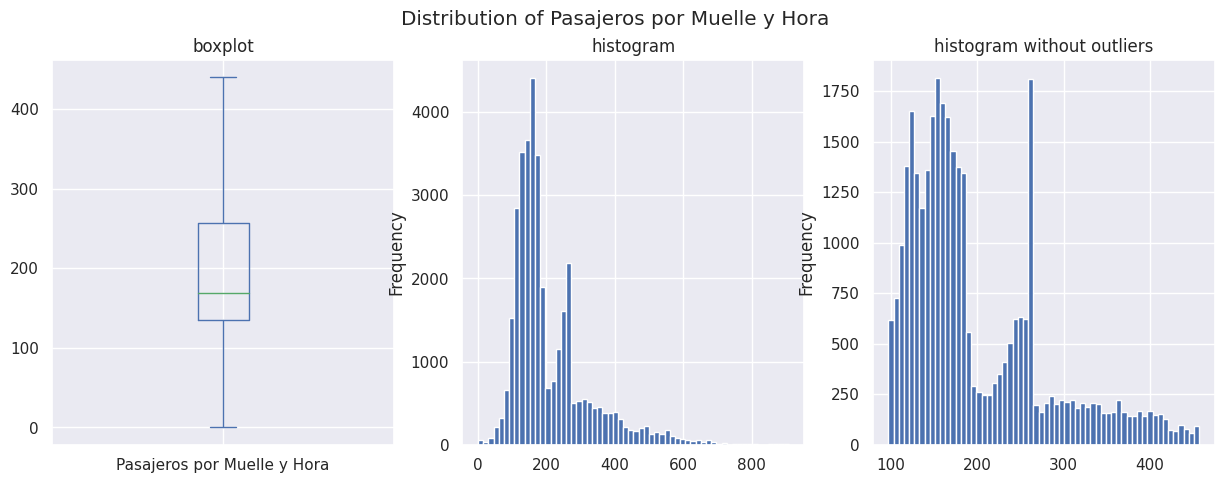

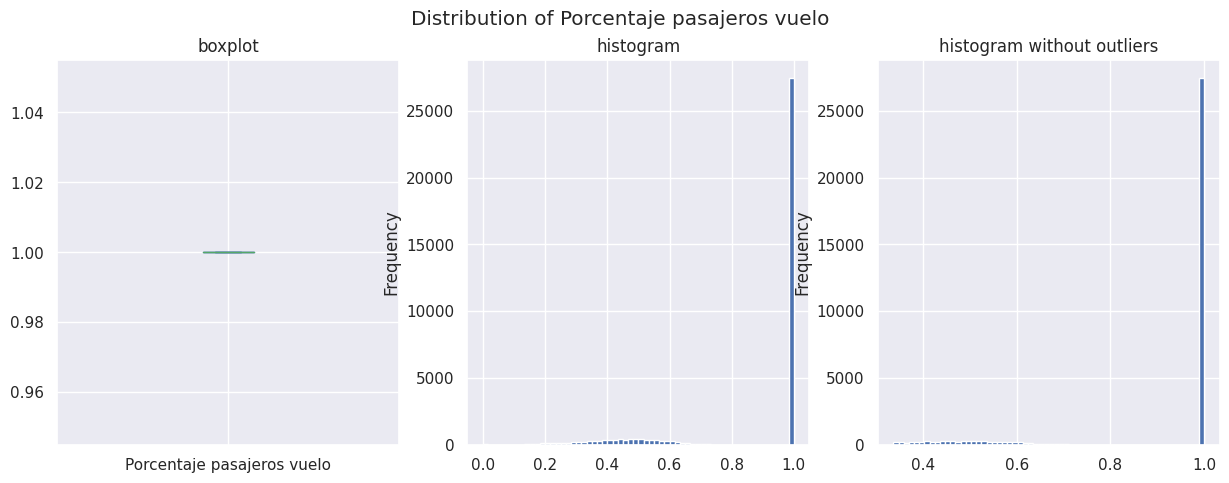

marca 6


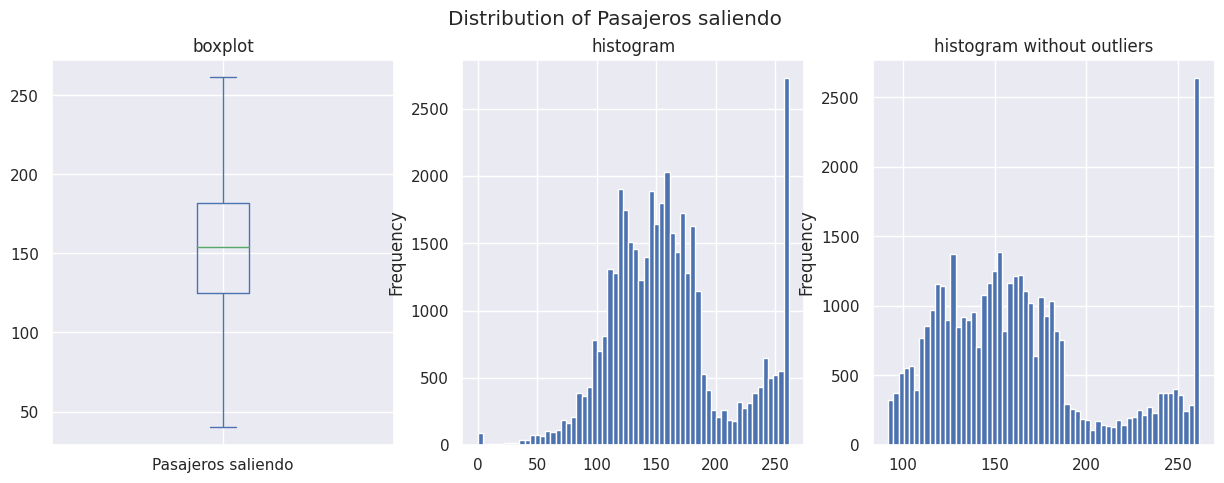

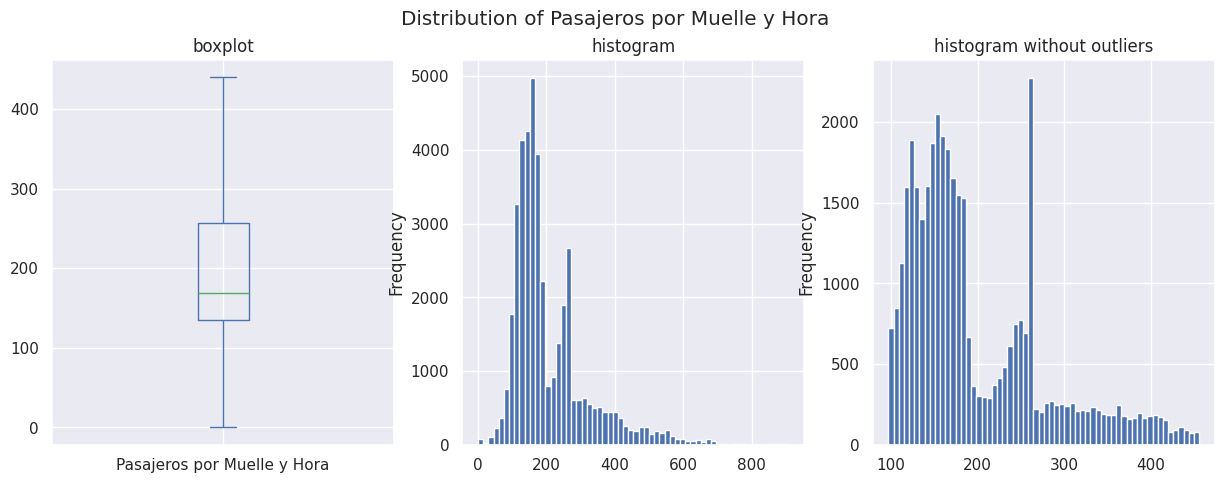

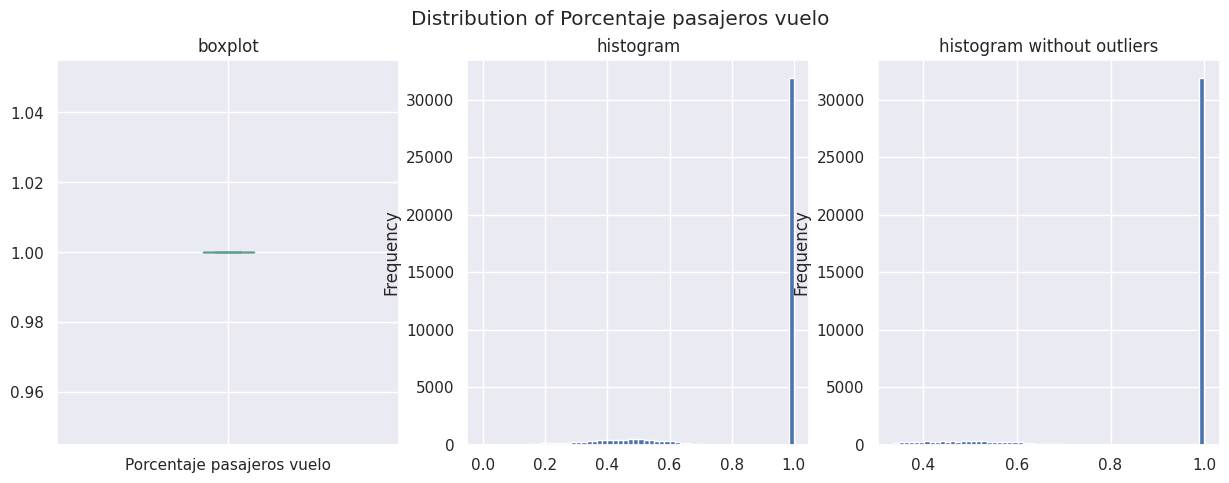

marca 7


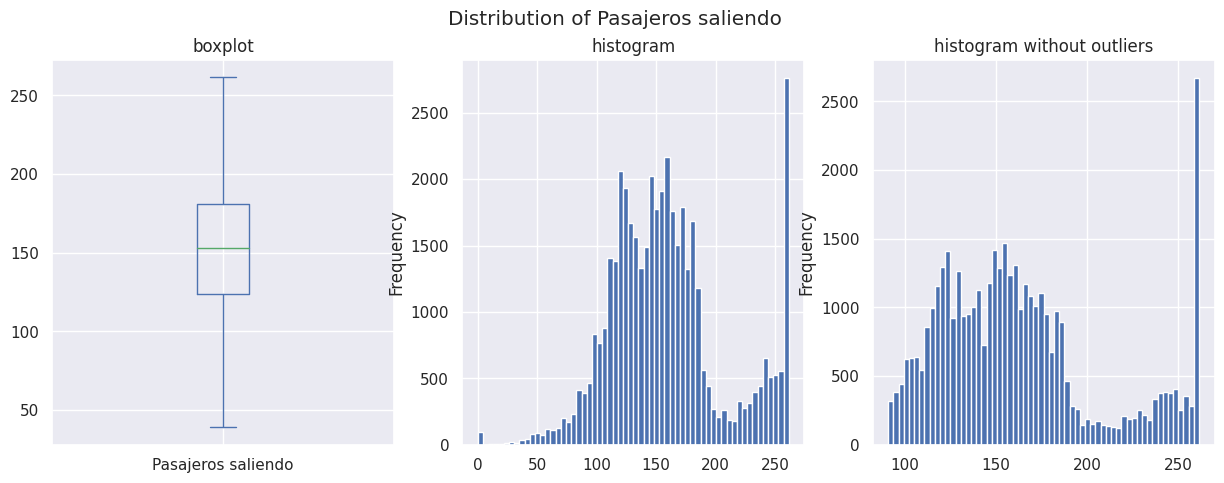

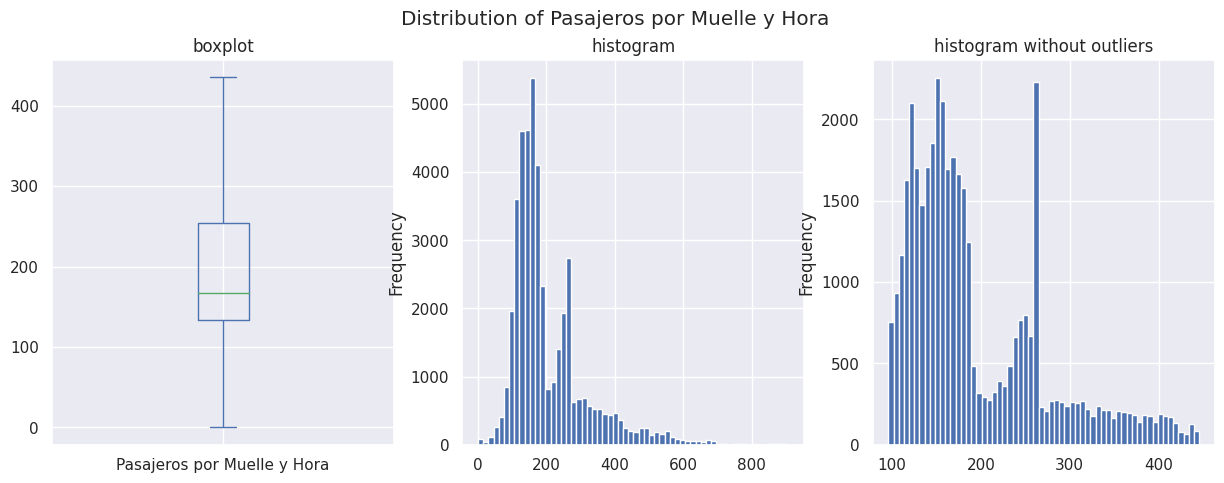

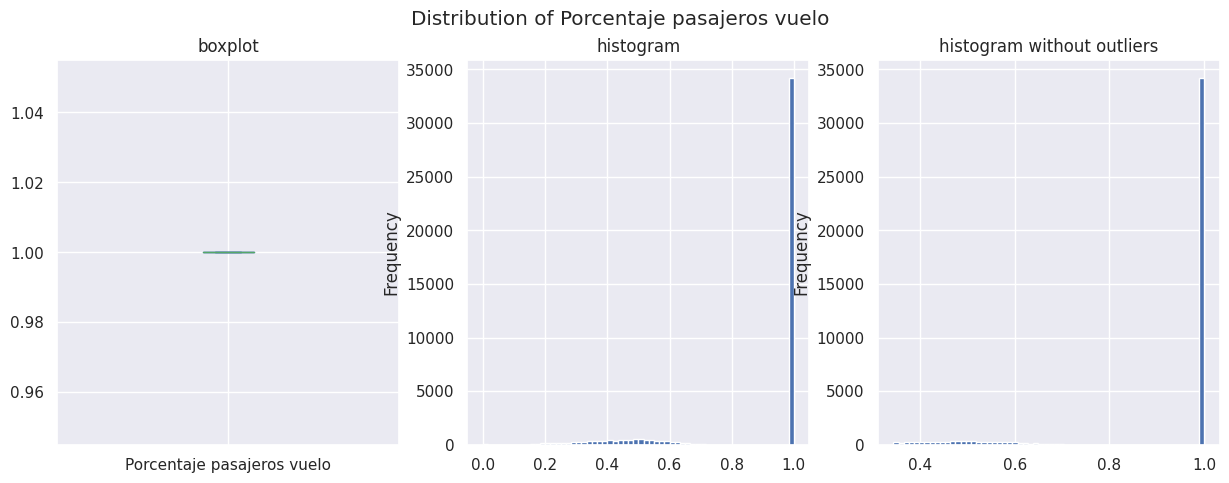

marca 9


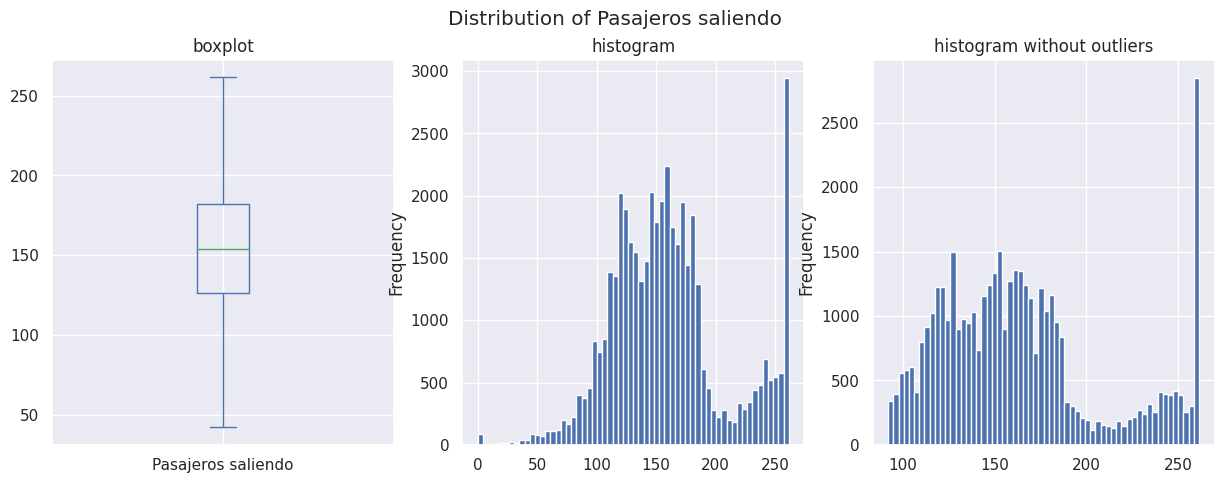

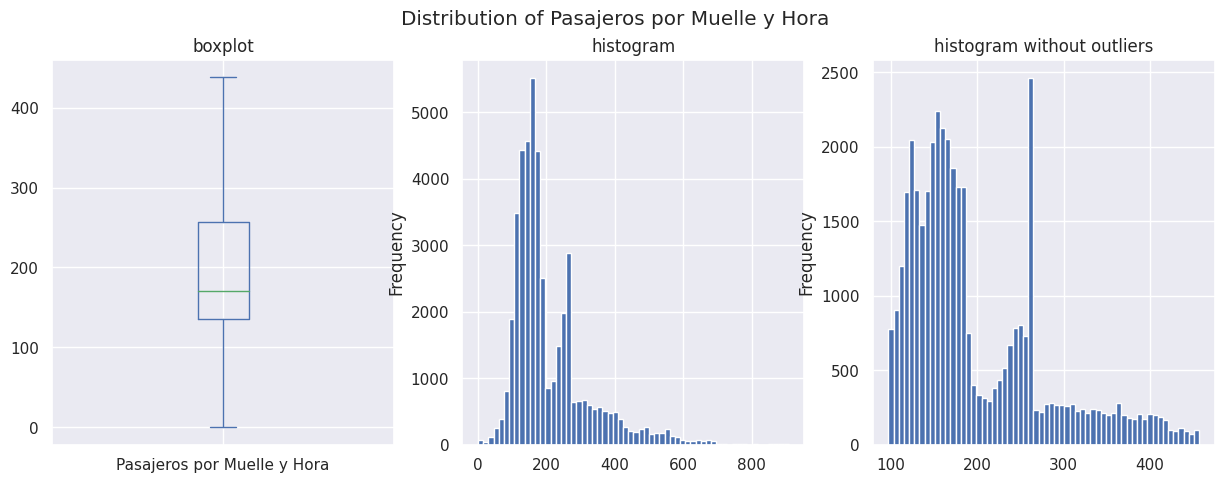

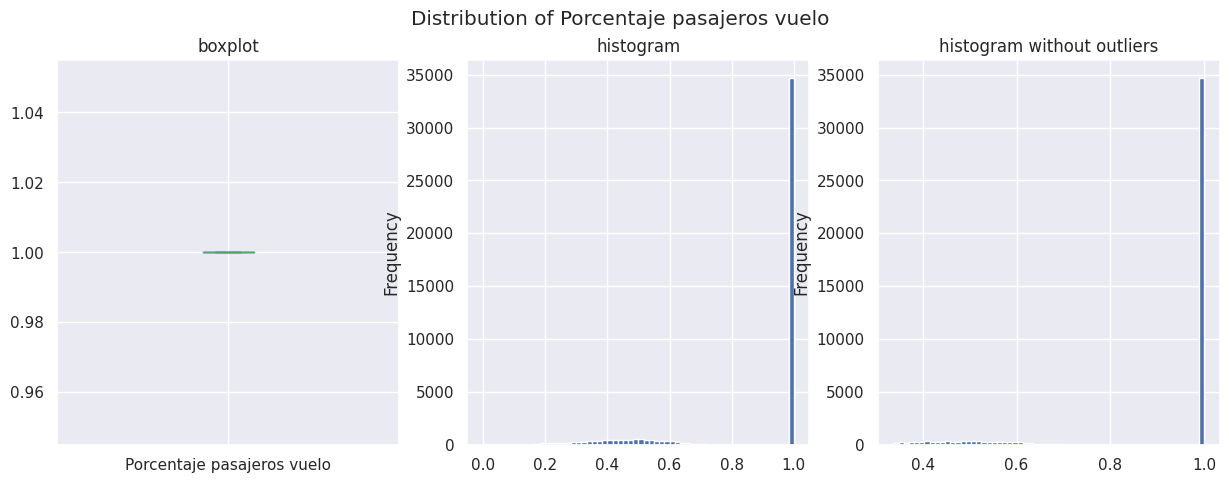

In [20]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    print(marca)
    for col in ["Pasajeros saliendo", "Pasajeros por Muelle y Hora", "Porcentaje pasajeros vuelo"]:
        univariate_utils.plot_column_distribution(
            df_marca_sales,
            col,
            (15,5),
            60
        )

### Asignacion de valor de venta y transacciones generado por pasajeros de un vuelo
Se usa el porcentaje de pasajeros de ese vuelo sobre el total de pasajeros en una hora determinada para asignar el valor y transacciones de venta como el valor o transacciones de venta del muelle en esa hora multiplicado por el porcentaje de pasajeros correspondientes al vuelo en esa hora.

**NOTA: Se generan valores encima de mil millones para la ganancia horaria de un muelle, y estos valores estan confirmados numericamente con test individuales y sobre el excel. Esto implica que pueden haber anomalias en el registro de estos valores en el Excel**

Se hace clipping dados los valores extremos de Parte de valor_venta.

In [21]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    df_marca_sales["Parte de valor_venta"] = (
        df_marca_sales["valor_venta"]
        * df_marca_sales["Porcentaje pasajeros vuelo"]
    ).fillna(0.0)

marca 1


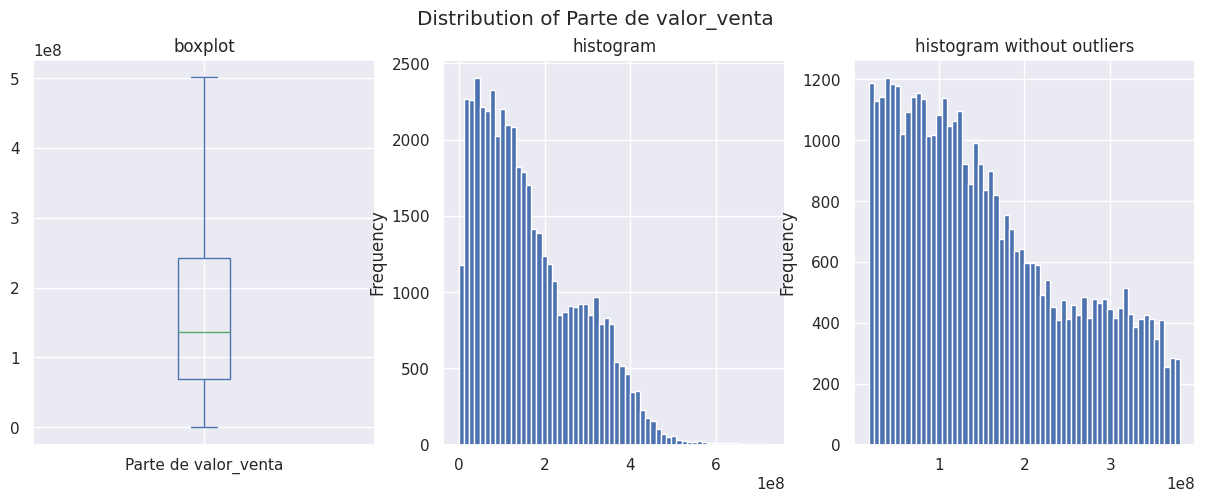

marca 10


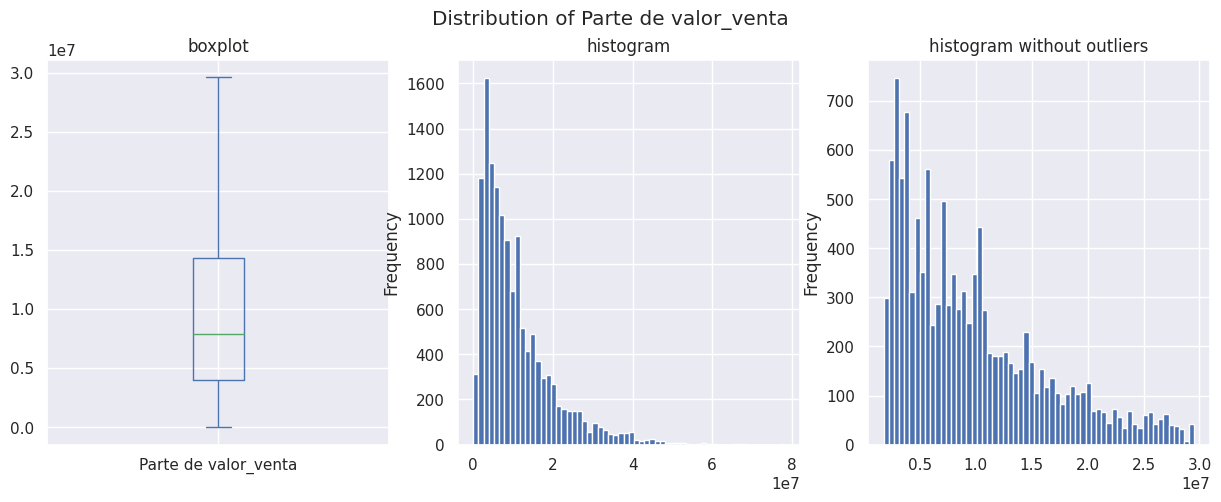

marca 2


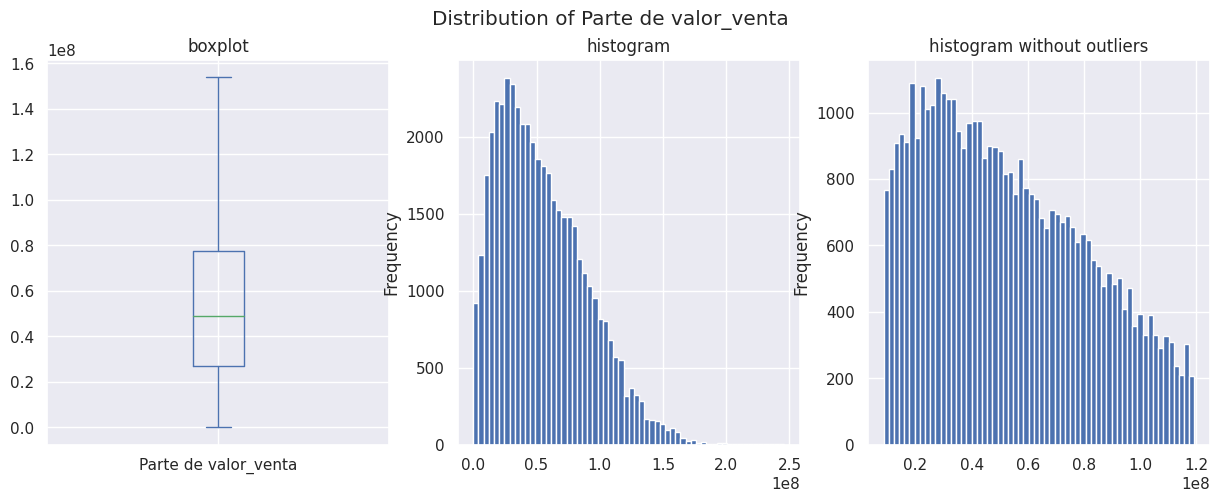

marca 3


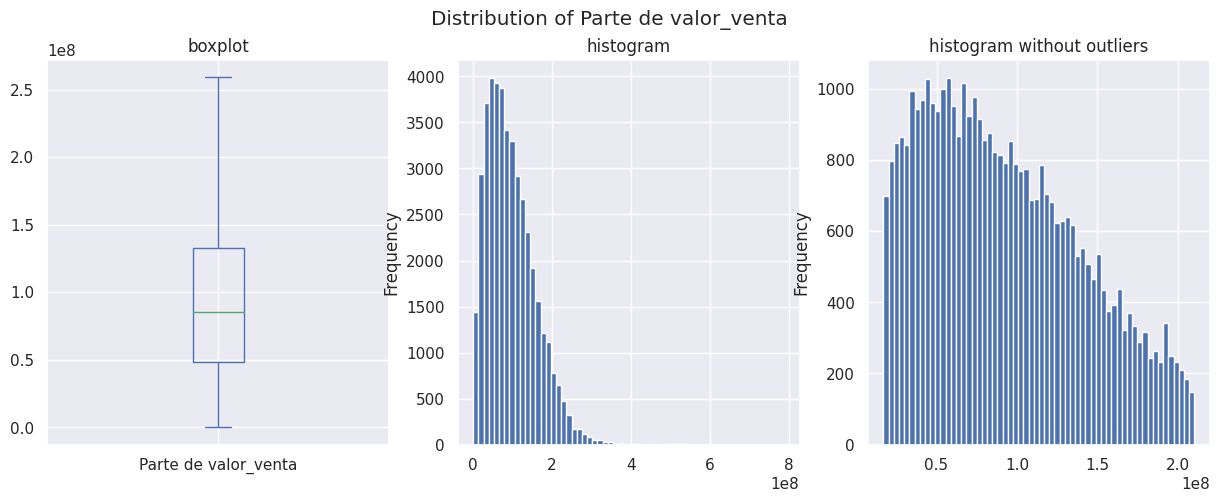

marca 5


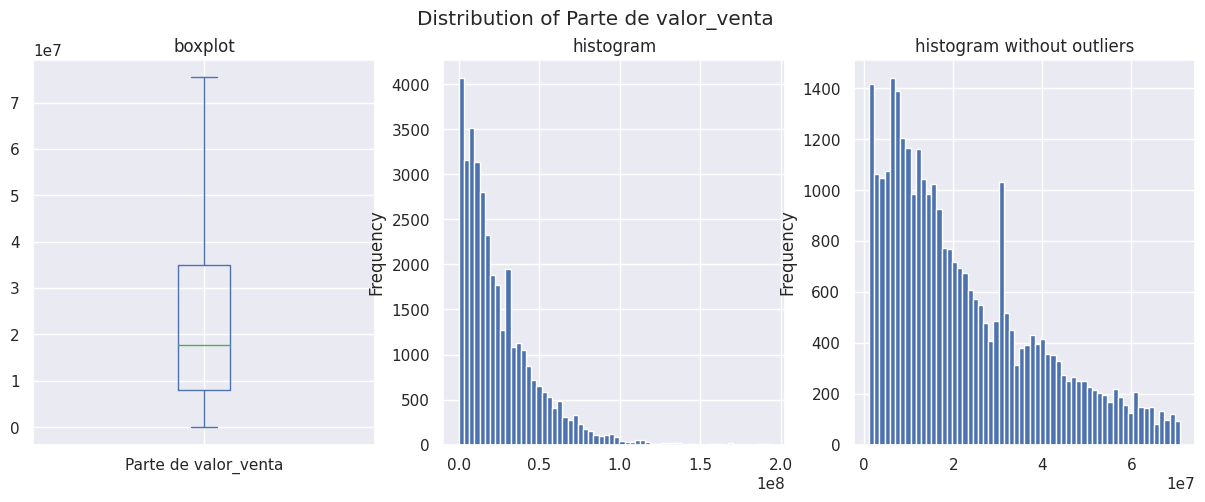

marca 6


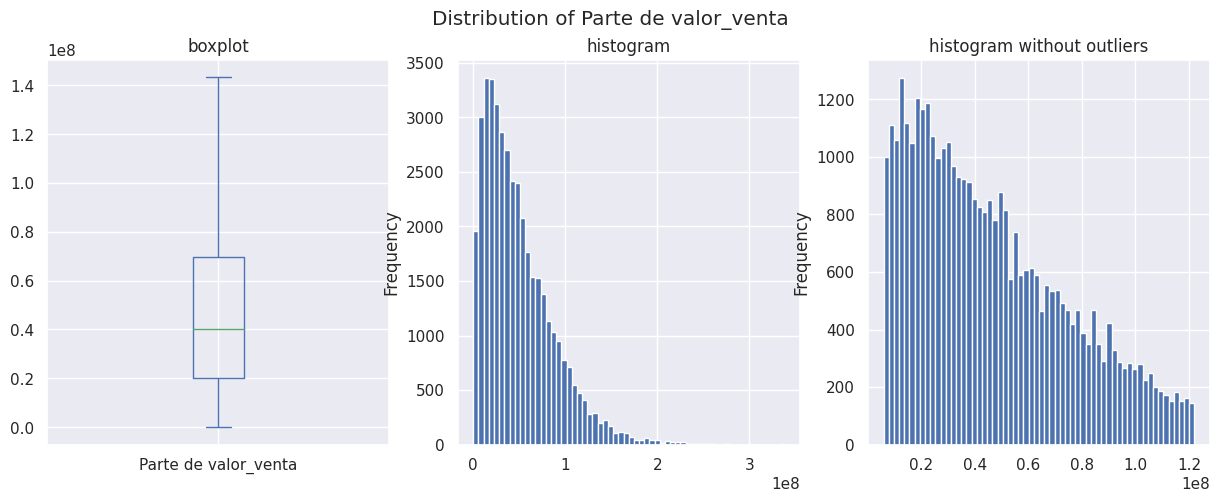

marca 7


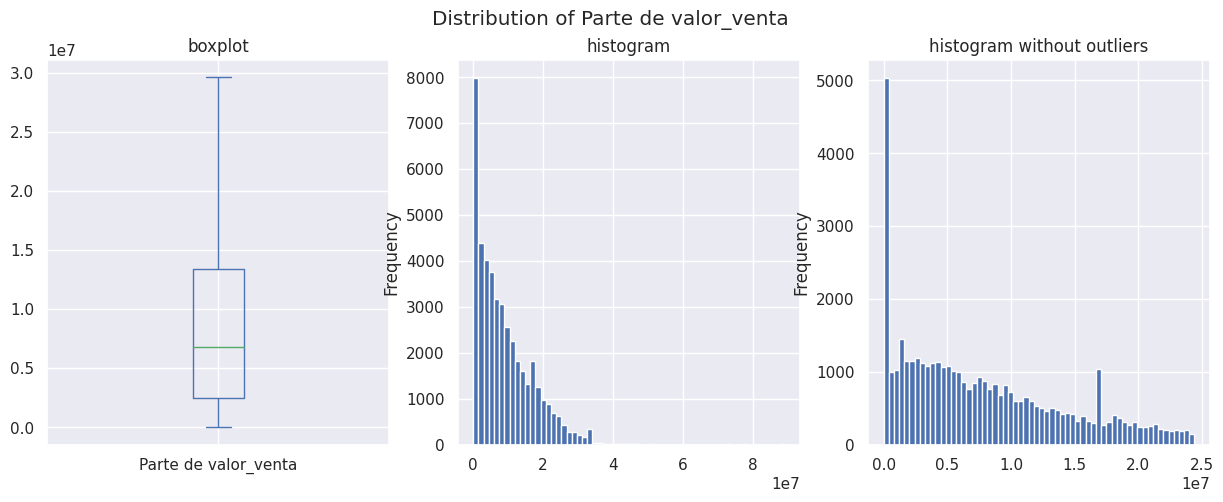

marca 9


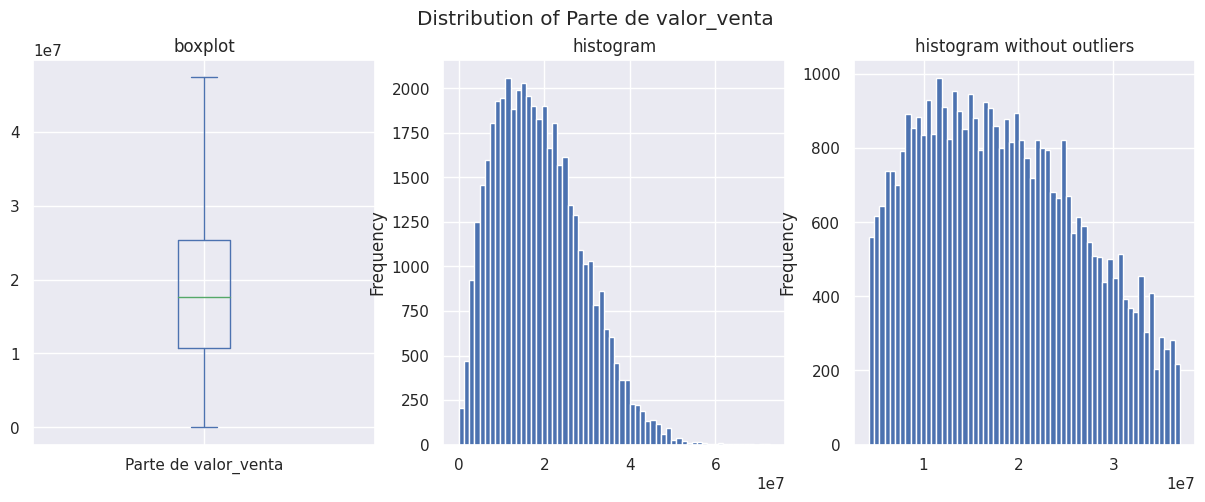

In [22]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    print(marca)
    univariate_utils.plot_column_distribution(
        df_marca_sales,
        "Parte de valor_venta",
        (15,5),
        60
    )

In [23]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    clip_data_by_iqr(df_marca_sales, "Parte de valor_venta", "top", 1.5)

marca 1


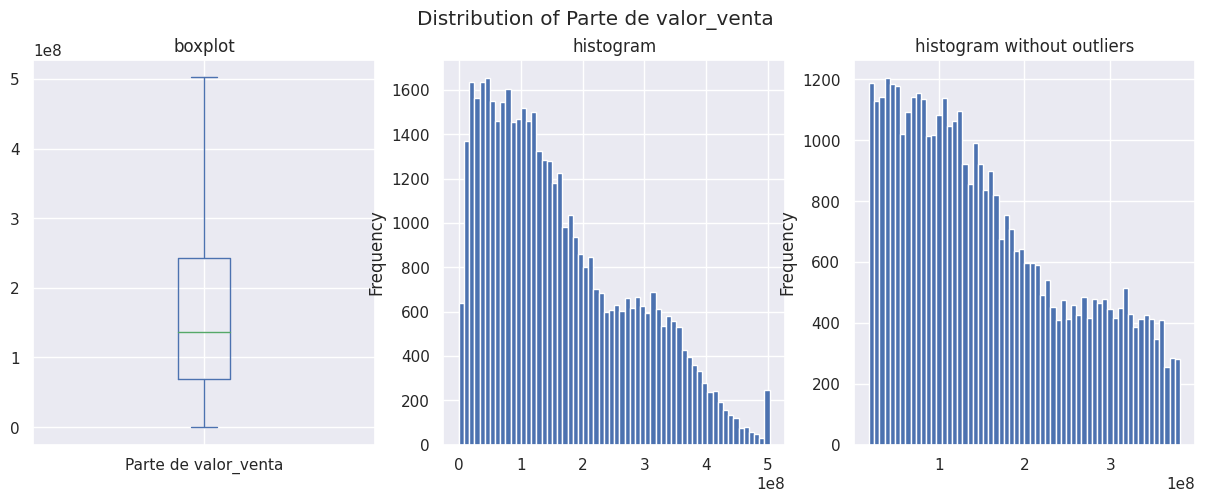

marca 10


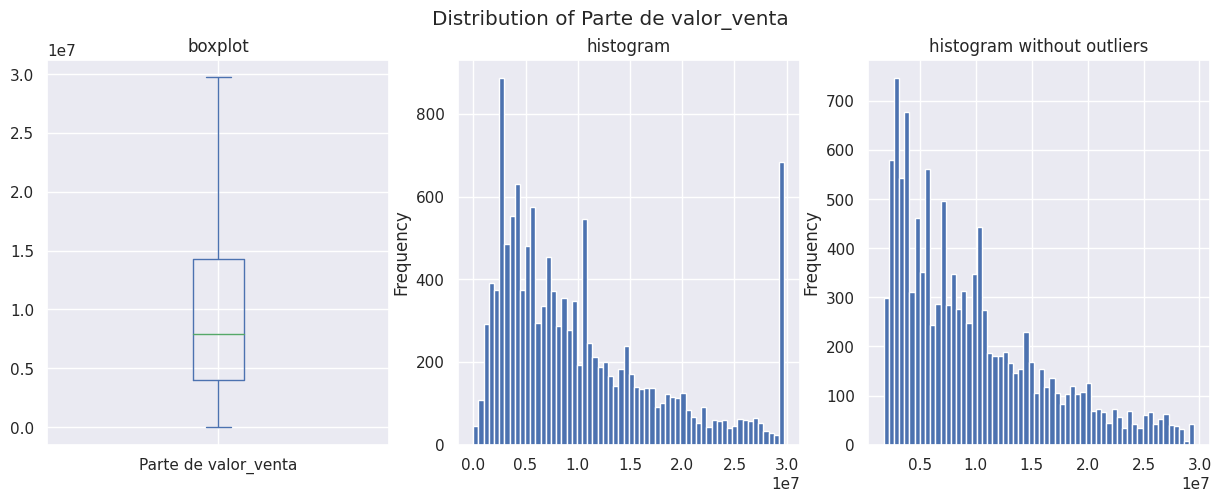

marca 2


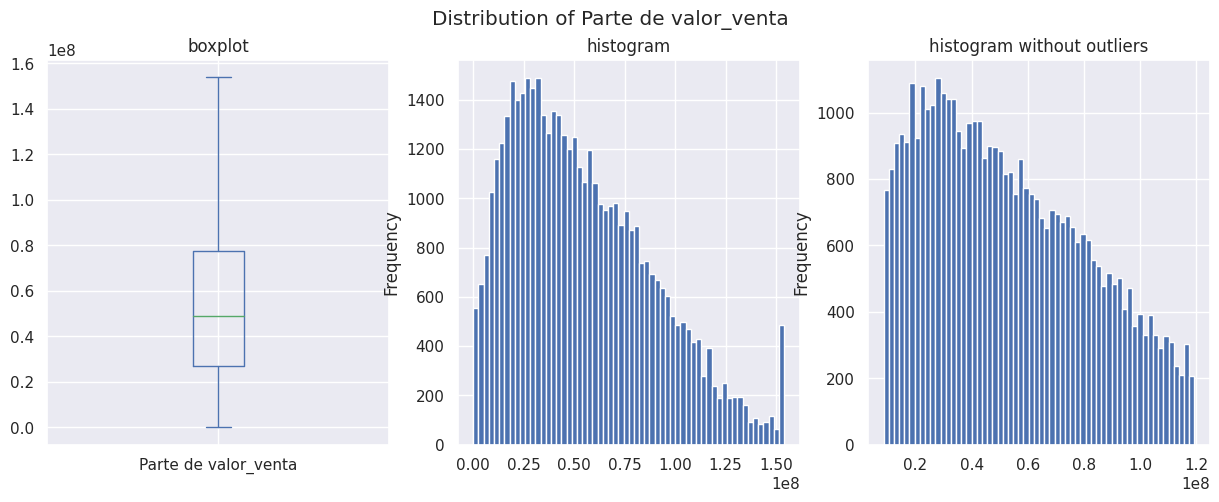

marca 3


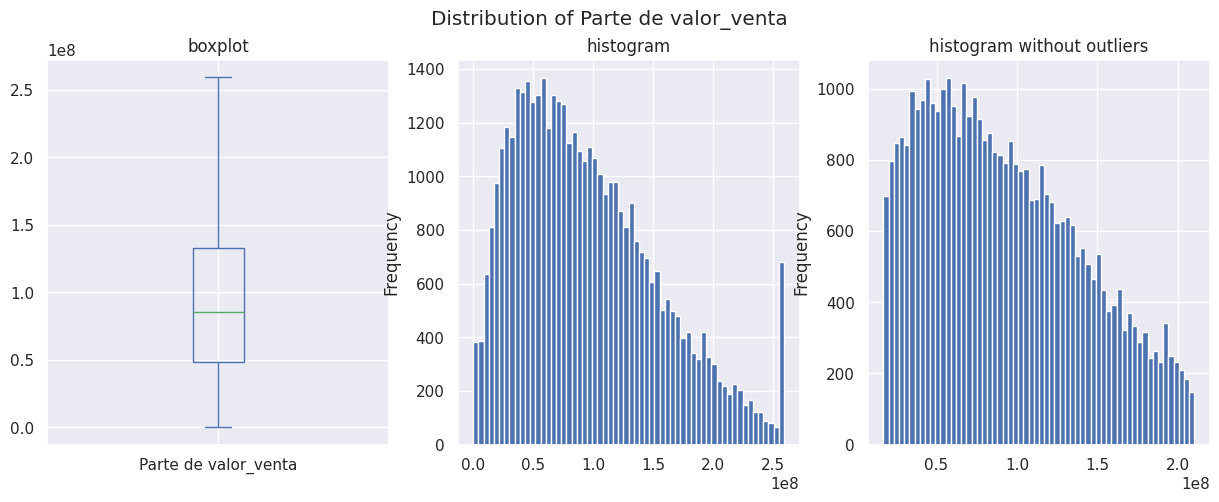

marca 5


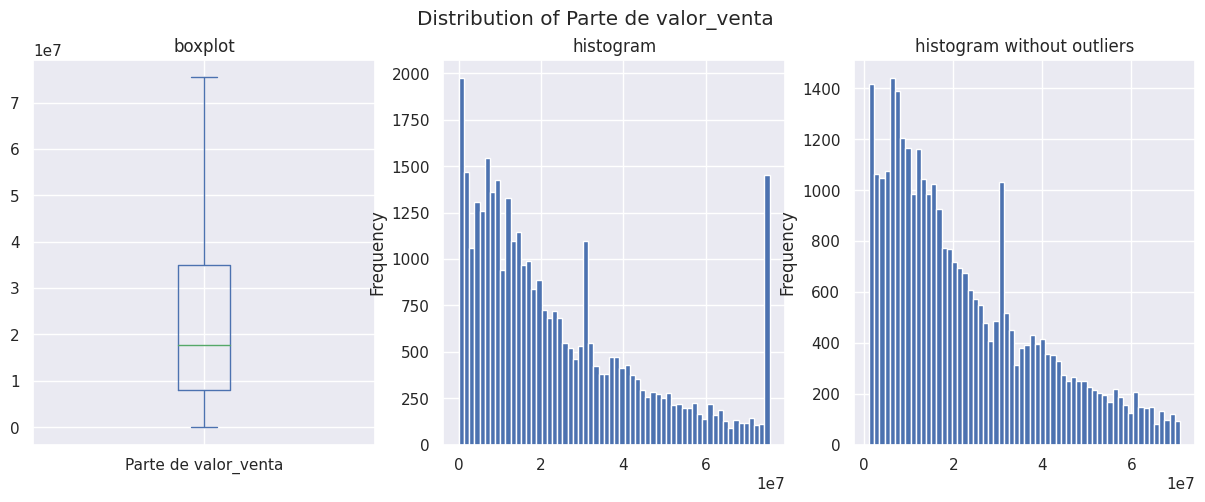

marca 6


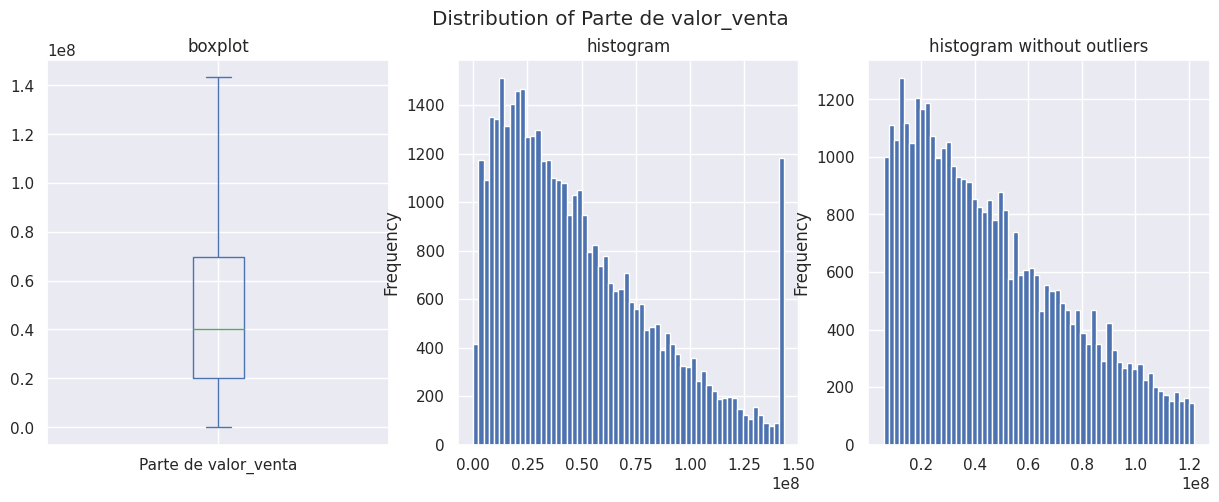

marca 7


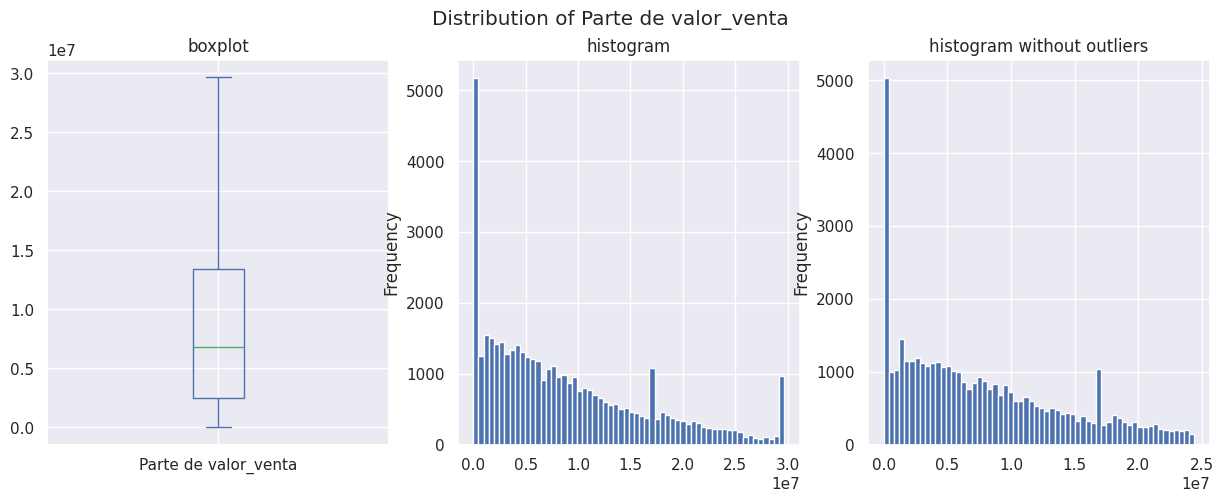

marca 9


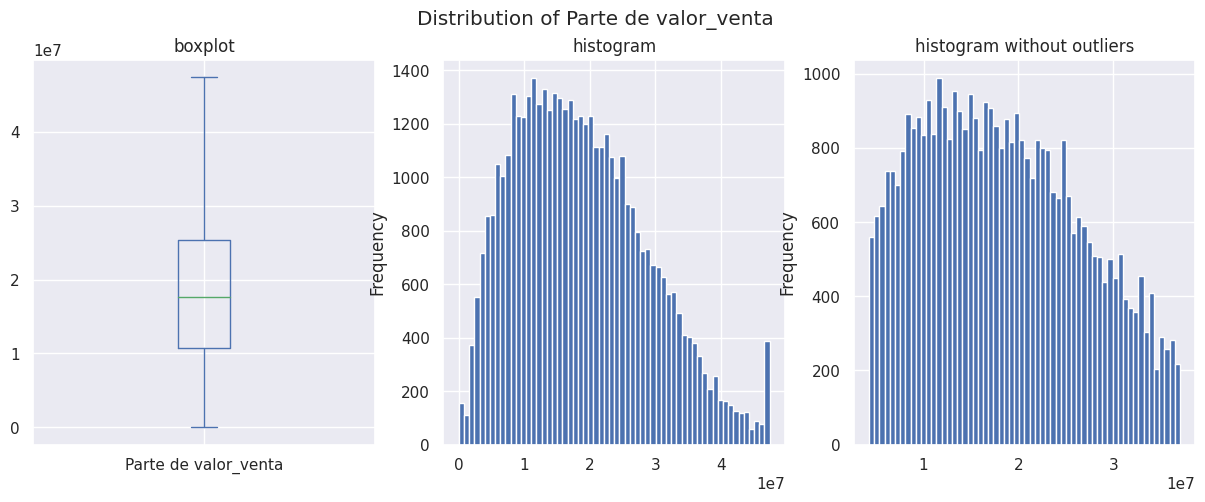

In [24]:
for marca, df_marca_sales in hourly_sales_per_marca.items():
    print(marca)
    univariate_utils.plot_column_distribution(
        df_marca_sales,
        "Parte de valor_venta",
        (15,5),
        60
    )

### Saving results to dataframe

In [25]:
for marca, df_marca_sales in tqdm(hourly_sales_per_marca.items()):
    df_marca_sales.to_parquet(f"data/{marca}.parquet")

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 30.18it/s]
